In [2]:
#analysis
import glob
import os, sys
current_dir = os.path.dirname(os.path.realpath('__file__'))
os.path.abspath(os.getcwd())
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT")
sys.path.append('C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation')

import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.init as weight_init

import scipy
from scipy.optimize import minimize
from functools import partial
import numpy as np
import numpy.ma as ma
import pickle
import re
import time
from tqdm.notebook import tqdm
from IPython.display import display, Math

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.cm as cmx
import sklearn
import sklearn.decomposition

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from utils import *
from analysis_functions import *
current_dir = 'C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation'

perfect_poisson_path = 'C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation\\experiments\\perfect_poisson'
makedirs(perfect_poisson_path)

C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
W = np.array([[1,0],[0,1]])
b = np.array([0,0])

W_in = np.array([[1,0],[0,1]])

W_out = np.array([[1,-1],[-1,1]])


#perfect dot motion
#4
W = np.array([[1.,0,0,0],[0,1,0,0], [1,0,0,0], [0,1,0,0]]).T 
N_rec = W.shape[0]
# W += np.random.normal(0, 0.0005, (N_rec, N_rec))
b = -0.7*np.array([0,0,1,1])

W_in = np.array([[0,0,1,0],[0,0,0,1]]).T

W_out = np.array([[1,-1,0,0],[-1,1,0,0]])

#limit for minimum of perfect integrator seems to be 4

# #3
# W = np.array([[1,0,0], [0,1,0], [1,1,0]]).T
# b = .5*np.array([-1,-1,1])

# W_in = np.array([[1,0,-1],[0,1,-1]]).T

# W_out = np.array([[1,-1,0],[-1,1,0]])

print(W, "\n", W_in, "\n", W_out)

[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 
 [[0 0]
 [0 0]
 [1 0]
 [0 1]] 
 [[ 1 -1  0  0]
 [-1  1  0  0]]


In [4]:
hidden_state = np.zeros(N_rec)
I = np.array([1,1])*1
relu_step_input(hidden_state, W, b, W_in, I)

array([0. , 0. , 0.3, 0.3])

In [5]:
with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\lr_clicks.pickle", 'rb') as handle:
    data_set = pickle.load(handle)
x, y, output_mask, trial_params = data_set


with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\data_cohs0_0.05.pickle", 'rb') as handle:
        data_set = pickle.load(handle)
x, y, output_mask, trial_params = data_set

In [6]:
# x, y, output_mask, trial_params = data_set
# inputs = torch.tensor(x, dtype=torch.float)
# batch_size = inputs.shape[0]
# maxT = inputs.shape[1]
# hs = np.zeros((batch_size, maxT,2))
# outputs = np.zeros((batch_size, maxT,2))
# for batch_i in range(batch_size):
#     h = [0,0]
#     for t in range(maxT):
#         I = inputs[batch_i,t,:]
#         h = relu_step_input(h, W, b, W_in, I)
#         hs[batch_i, t,:] = h
#         output = np.dot(W_out,h)
#         outputs[batch_i, t,:] = output

In [10]:
exp_list = glob.glob(current_dir+"\\experiments\\poisson_clicks\\cued\\*")
# exp_list = glob.glob(current_dir+"\\experiments\\poisson_clicks\\*idx*")
exp_list = sorted(exp_list, key = lambda x: int(x[-10:]))

last_i = 2
exp_path = exp_list[-last_i]
idx = exp_path[-10:]

with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)
    
N_in = 2
N_out = 2
rnn_model = RNNModel(N_in, N_out, N_rec, n_layers=1, transform_function='relu').to(device)

with torch.no_grad():
    rnn_model.rnn.all_weights[0][0][:] = torch.tensor(W_in, dtype=torch.float)
    rnn_model.rnn.all_weights[0][1][:] = torch.tensor(W, dtype=torch.float)
        #biases of hidden neuron
    rnn_model.rnn.all_weights[0][2][:] =  torch.tensor(b, dtype=torch.float)
    rnn_model.rnn.all_weights[0][3][:] =  torch.zeros((N_rec), dtype=torch.float)
        #fully connected layers
    rnn_model.fc.weight = nn.Parameter(torch.tensor(W_out, dtype=torch.float))
    rnn_model.fc.bias = nn.Parameter(torch.zeros((N_out), dtype=torch.float))
    
    
#initialize hidden states
inputs = torch.tensor(x, dtype=torch.float)
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()

inputs = torch.tensor(x, dtype=torch.float)
yhat, hidden = rnn_model(inputs)
yhat = yhat.detach().numpy()

In [11]:
stimulus_masked = np.where(x>.5, x, 0)
input_sum = np.sum(stimulus_masked, axis=1)
input_sum_index = np.argmax(input_sum, axis=1)
# excludeequals = np.where(input_sum[:,0]==input_sum[:,1],False,True)

coherence_array = np.array([trial_params[i]['coherence'] for i in range(trial_params.size)])
coherences = np.unique(coherence_array)
chosen = np.argmax(np.mean(yhat*output_mask, axis=1), axis = 1)
truth = input_sum_index
response_correctness = np.equal(truth, chosen)
choice_proportion_per_coherence = np.array([np.mean(chosen[np.where(coherence_array == coherence)]) for coherence in coherences])
average_accuracy_per_coherence = np.array([np.mean(response_correctness[np.where(coherence_array == coherence)]) for coherence in coherences])
accuracy = np.mean(response_correctness)
accuracy

0.9997

In [12]:
difference = np.sum(stimulus_masked[:,:,0] - stimulus_masked[:,:,1], axis=1)
from scipy.stats import binned_statistic

mean_stat = binned_statistic(coherence_array, 1-chosen, 
                             statistic='mean', 
                             bins=coherences.shape[0]-1,
                             range=(0, 0.05))

maxabs = np.max(np.abs(difference))
nbins = 20
mean_stat = binned_statistic(difference, 1-chosen, 
                             statistic='mean', 
                             bins=nbins,
                             range=(-maxabs, maxabs))

mean_stat.statistic
bin_width = (mean_stat.bin_edges[-1]-mean_stat.bin_edges[-2])

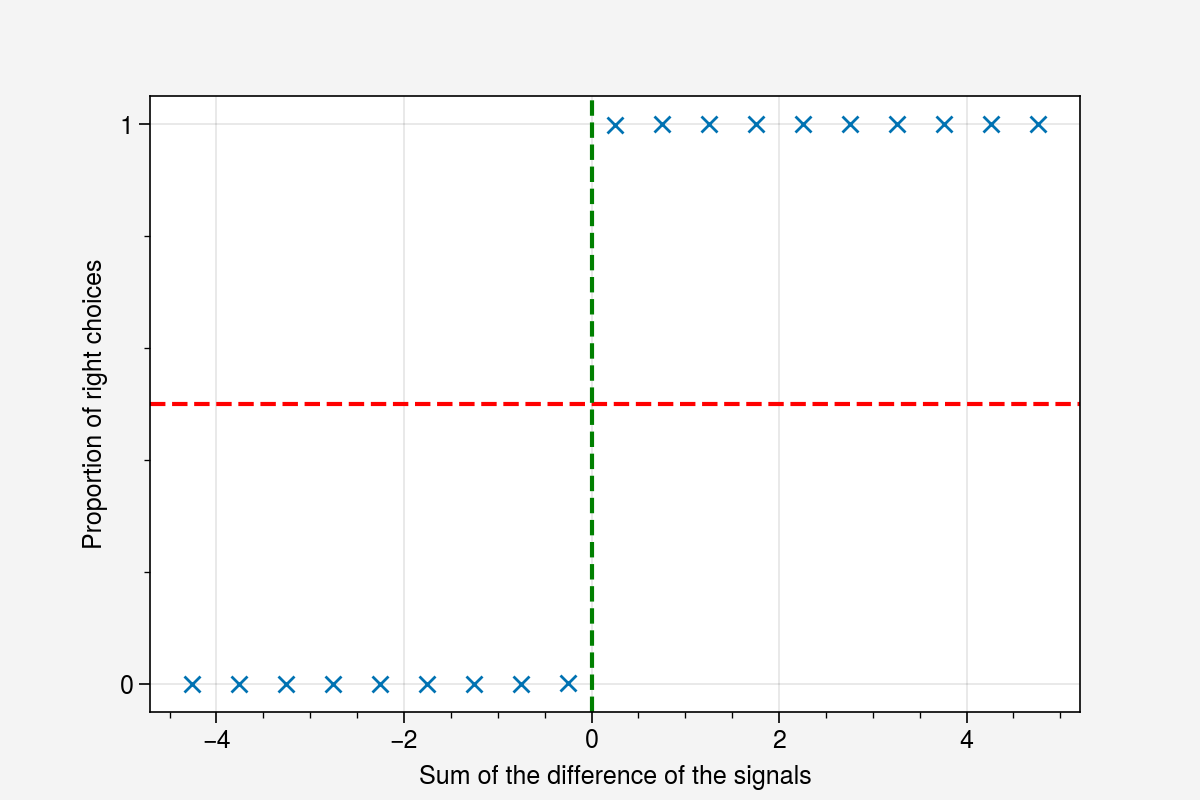

In [13]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.plot(mean_stat.bin_edges[2:]-bin_width/2., mean_stat.statistic[1:], 'x');
# ax.plot(difference, 1-chosen, 'x');
ax.set_xlabel("Sum of the difference of the signals")
ax.set_ylabel("Proportion of right choices")
ax.set_yticks([0,1])
ax.axhline(y = 0.5, color = 'r', linestyle = '--')
ax.axvline(x = .0, color = 'g', linestyle = '--')
plt.savefig(perfect_poisson_path + '\\psyco_curve_perfectPD.pdf')

In [14]:
# accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index = get_accuracy_poissonclicks(x, yhat, output_mask, trial_params)

# accuracy, response_correctness, choice_proportion_per_coherence, average_accuracy_per_coherence = get_accuracy_perceptualdiscrimination(y, yhat, output_mask, trial_params)

# accuracy


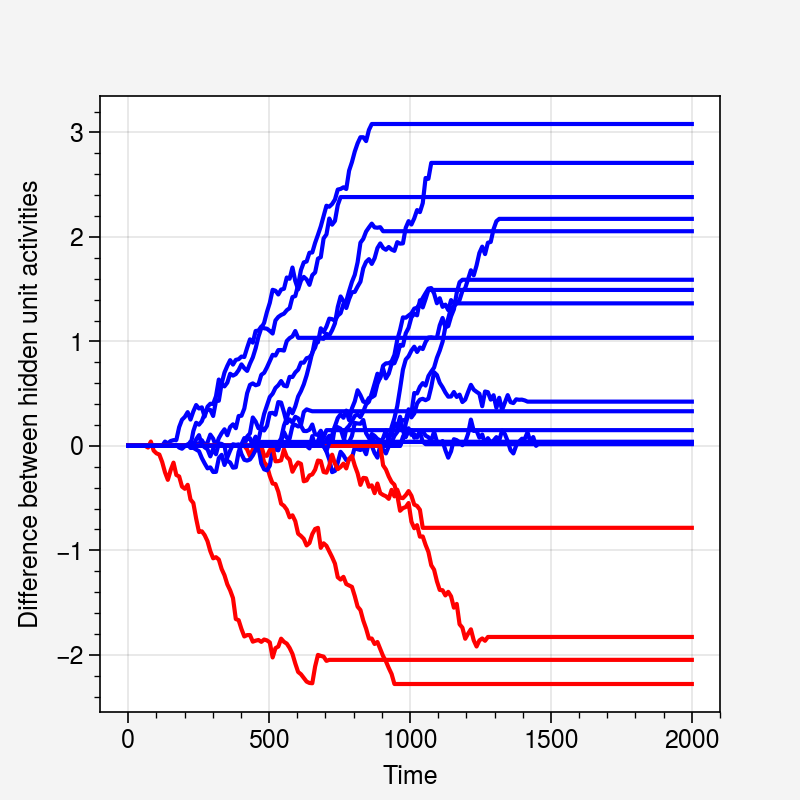

In [18]:
colors = ['b', 'r']
neuron_i = 0
for batch_i in range(20):
        plt.plot(np.linspace(0, training_kwargs['T'], hidden_states[batch_i, :, neuron_i].shape[0]),
                 hidden_states[batch_i,:,0].T-hidden_states[batch_i,:,1].T, color=colors[input_sum_index[batch_i]]);
    # for neuron_i in range(2):
    #     plt.plot(np.linspace(0, training_kwargs['T'], hidden_states[batch_i, :, neuron_i].shape[0]),
    #              hidden_states[batch_i,:,neuron_i].T, color=colors[highest_click_count_index[batch_i]]);
    # plt.plot(hs[batch_i,:,0].T-hs[batch_i,:,1].T);
    # plt.plot(np.linspace(0, training_kwargs['T'], hidden_states[batch_i, :, neuron_i].shape[0]), x[batch_i,:,0])
    # plt.plot(np.linspace(0, training_kwargs['T'], hidden_states[batch_i, :, neuron_i].shape[0]), x[batch_i,:,1])

plt.xlabel("Time")
plt.ylabel("Difference between hidden unit activities")
plt.savefig(perfect_poisson_path + '\\hidden_activity_10.pdf')

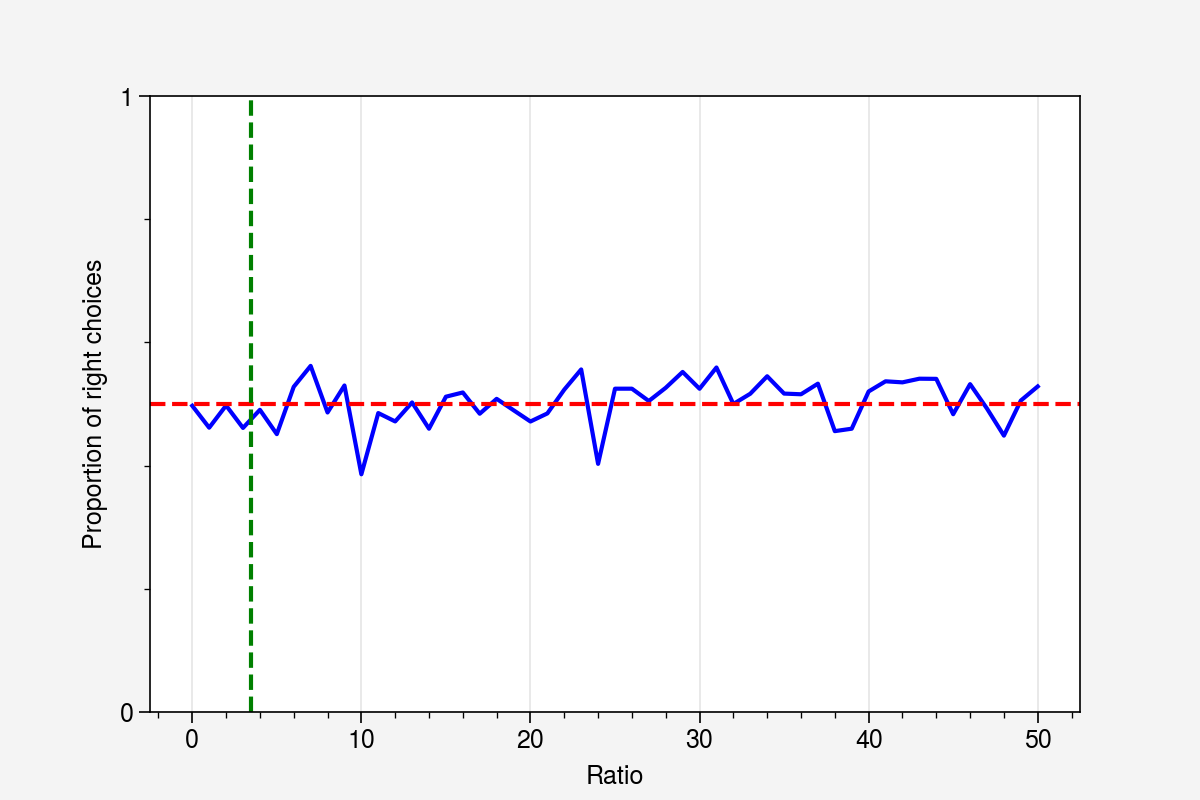

In [19]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
# ax.plot(1-choice_proportion_per_ratio, 'b')
ax.plot(1-choice_proportion_per_coherence, 'b')
# coherence_labels=['1:39', '3:37', '9:31', '14:26', '26:14', '31:9', '37:3', '39:1']
# ax.set_xticks(range(len(coherence_labels)), coherence_labels);
ax.set_xlabel("Ratio")
ax.set_ylabel("Proportion of right choices")
ax.set_yticks([0,1])
ax.axhline(y = 0.5, color = 'r', linestyle = '--')
ax.axvline(x = 3.5, color = 'g', linestyle = '--')
# plt.savefig(training_kwargs['figures_path'] + "psycho.pdf")

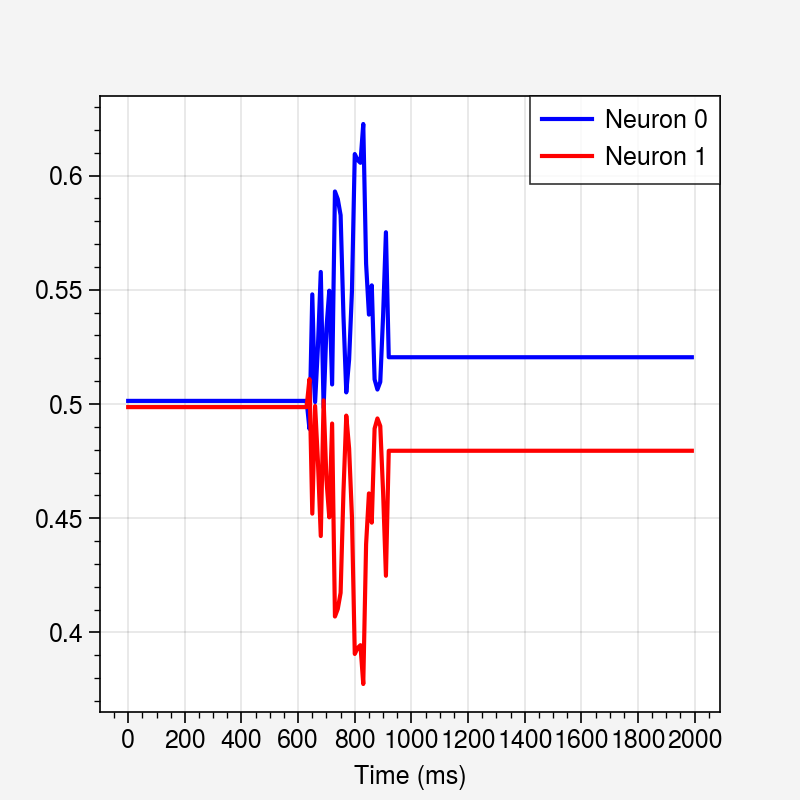

In [20]:
batch_i = 7
# for i in range(x.shape[1]):
#     if x[batch_i,i,0] > 0:
#         plt.axvline(x = i, color = 'g', linestyle = '--')
#     elif x[batch_i,i,1] > 0:
#         plt.axvline(x = i, color = 'y', linestyle = '--')
# plt.plot(x[batch_i,:,1])

plt.plot(yhat[batch_i,:,0], 'b')
plt.plot(yhat[batch_i,:,1], 'r')

# plt.plot(y[batch_i,:,0])
# plt.plot(y[batch_i,:,1])

N_clicks = np.sum(x[batch_i,...], axis=0)
# plt.title("Rates: " + str(int(trial_params[batch_i]['lambdas'][0])) +":"+ str(int(trial_params[batch_i]['lambdas'][1])) + ",   Clicks (%s,%s)"%(int(N_clicks[0]), int(N_clicks[1])));
# plt.title("Ratio:" + str(trial_params[batch_i]['ratio']) + ",   Clicks (%s,%s)"%(int(N_clicks[0]), int(N_clicks[1])));
sum(N_clicks)/trial_params[batch_i]['stim_duration']*100
plt.xlabel('Time (ms)')
plt.xticks(range(0, x.shape[1]+1, 20), range(0, x.shape[1]*10+10, 200));
plt.legend(['Neuron 0', 'Neuron 1', 'Click left', 'Click right'])
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('b')
leg.legendHandles[1].set_color('r')
# leg.legendHandles[2].set_color('g')
# leg.legendHandles[3].set_color('y')
plt.savefig(perfect_poisson_path + "\\example_trajectory_wclicks.pdf")

In [492]:
wrong_batches = np.where(truth != chosen)[0]

In [493]:
colors = ['b', 'r']
batch_i = wrong_batches[0]
print(np.sum(stimulus_masked[batch_i,:,0]-stimulus_masked[batch_i,:,1]))

# for batch_i in wrong_batches[:1]:

# plt.plot(hs[batch_i,:,0], color=colors[input_sum_index[batch_i]]);
# plt.plot(hs[batch_i,:,1], color=colors[input_sum_index[batch_i]]);

plt.plot(x[batch_i,:,0])
plt.plot(x[batch_i,:,1])
    

# for i in range(maxT):
#     if x[batch_i,i,0] > 0:
#         plt.axvline(x = i, color = 'g', linestyle = '--')
#     elif x[batch_i,i,1] > 0:
#         plt.axvline(x = i, color = 'y', linestyle = '--')
        
# print(N_clicks[batch_i])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [266]:
np.sum(stimulus_masked[batch_i,:,0]-stimulus_masked[batch_i,:,1])/np.mean(np.abs(np.sum(stimulus_masked[:,:,0]-stimulus_masked[:,:,1], axis=1)), axis=0)

-0.00017769552186829878

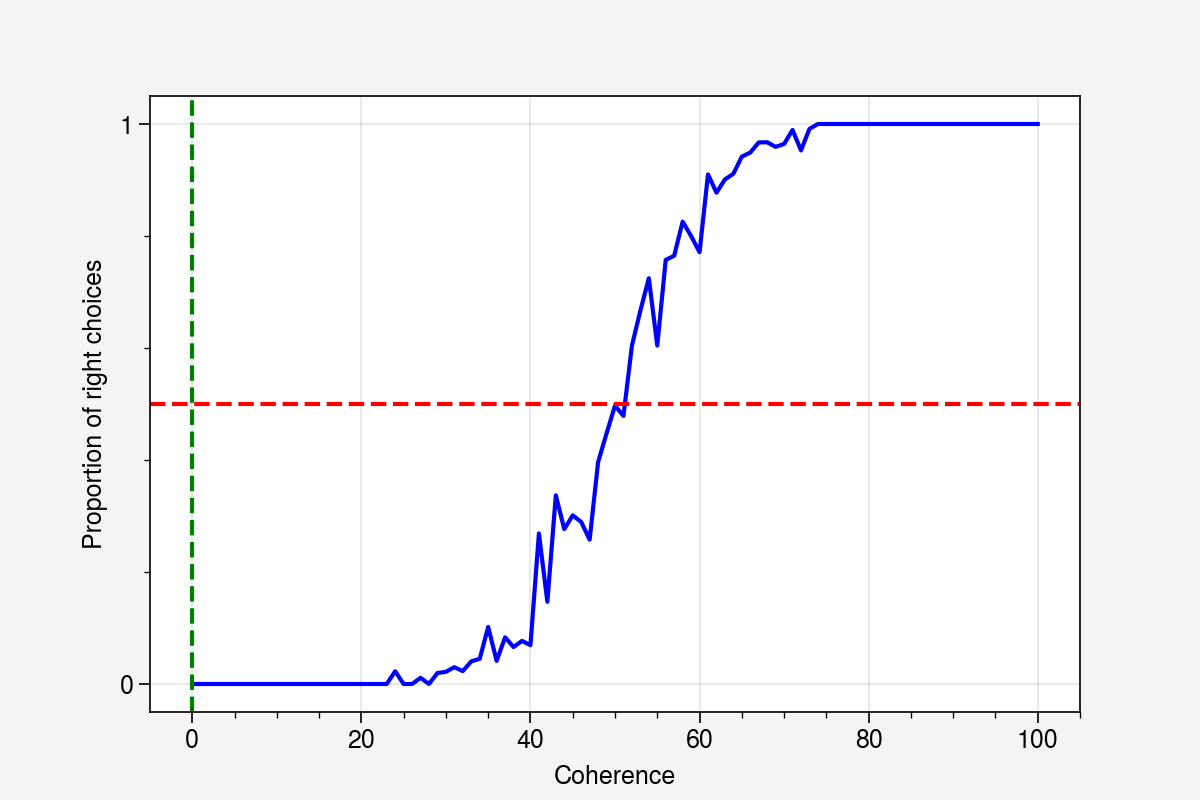

In [21]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
all_directed_coherences, average_accuracy_per_coherence = get_psycho_curve(y, yhat, output_mask, trial_params)
plt.plot(1-average_accuracy_per_coherence, 'b')
# ax.plot(all_coherences, average_accuracy_per_coherence_left, 'b')
# ax.plot(-all_coherences, average_accuracy_per_coherence_right, 'b')
ax.set_xlabel("Coherence")
ax.set_ylabel("Proportion of right choices")
ax.set_yticks([0,1]) 
ax.axhline(y = 0.5, color = 'r', linestyle = '--')
ax.axvline(x = 0, color = 'g', linestyle = '--')
# plt.savefig(training_kwargs['figures_path'] + "/psycho_%s.pdf"%idx)